In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Öncelikle geçen haftalardan işimize yarıyacak dosya okuma ve korelasyon ortalama filtresi fonksyonlarını dahil edelim

In [3]:
def mypgmread(name):
    with open(str(name),'rb') as mypgm:
        file = mypgm.read()
        header=''
        width=''
        height=''
        resolution=''
        #Data type is first two characters followed by end line
        for x in range (0,2):
            header=header+chr(file[x])
        # Check for comments starting from third character
        # We also need to itarete once more after each variable to get trough line breaks
        x=3
        if (chr(file[x])=='#'):
            comment = True
            while comment:
                if (chr(file[x])=='\n')and(chr(file[x+1])!='#'):
                    comment = False
                x = x+1
        # Width an Height are seperated by white space. 
        while (chr(file[x])!=' '):
            width = width+chr(file[x])
            x = x+1
        x = x+1
        while(chr(file[x])!='\n'):
            height = height+chr(file[x])
            x = x+1
        x = x+1
        while(chr(file[x])!='\n'):
            resolution = resolution+chr(file[x])
            x = x+1
        x = x+1
        
        bytepixels = file[x:]
        pixels = list(bytepixels)
        mypgm.close()
    return name,int(width),int(height),int(resolution),pixels

In [4]:
def correlationloop(size,fix1,fix2,pixels):
    #for this lab we will only use square masks 
    size2=size
    mask = np.array([0]*(size*size))
    mask = np.reshape(mask,(size,size2))
    #Define the constants we will use in loops for example if the mask is 3x3 we should get the values from positions (-1,-1)to(1,1) from center
    #If we do not cast values to integers for loop will give us headaches
    boundry1=((size-1)/2)
    boundry1=int(boundry1)
    boundry2=((size2-1)/2)
    boundry2=int(boundry2)
    x,y=pixels.shape
    for i in range(size):
        for j in range (size2):
            if((fix1-boundry1+i)>x) and ((fix2-boundry2+j)>y): #To assign zero if the mask value position is not greater than our pixel array
                mask[i][j]=0
            if((fix1-boundry1+i)>=0) and ((fix2-boundry2+j)>=0) and ((fix1-boundry1+i)<x) and ((fix2-boundry2+j)<y): #Only gets the values from original array if all within boundries 
                mask[i][j]=pixels[fix1-boundry1+i][fix2-boundry1+j]
            if((fix1-boundry1+i)<0) and ((fix2-boundry2+j)<0): #To assign zero if the mask value position is lesser than our pixel array
                mask[i][j]=0 #Later we might change this to mirroring or periodic repeating

    #This line forward calculates the avarage of the values within the mask
    smoothpixel=0
    for a in range(size):
        for b in range(size2):
            smoothpixel=smoothpixel+((mask[a][b])/(size*size2))
    smoothpixel=int(smoothpixel)
    return(smoothpixel)

In [5]:
def mypgmcorrelationfilter(size,pixels):
    #check if the mask index is odd so we can determine the center
    if ((size%2)==0):
        print('box size is not odd')
    pixels = np.array(pixels)
    pixels = np.reshape(pixels,(h,w))
    for o in range(h):
        for p in range(w):
            pixels[o][p]=correlationloop(size,o,p,pixels)
    return pixels

## Bu Hafta Kullanılacak Fonksyonların Tanımları

### 1) Histogram Equalisation'a dair Fonksyonlar

In [6]:
def mypgmhistogram(w,h,res,pixels,normalise): 
    pixels = np.array(pixels)
    pixels = pixels.astype(int)
    pixels = np.reshape(pixels,(h,w))
    #First we define the horizontal axis for our histogram which will hold the gray level values
    hr = np.arange(0,res+1,1)
    for a in range(0,res+1):
        hr[a]=0
    #With this loop we fill the histogram with how many of the gray values are present in image
    for x in range(0,res+1):
        for i in range(0,h):
            for j in range(0,w):
                if (pixels[i][j] == x):
                    hr[x]=hr[x]+1
    #To normalise our histogram we need to divide each value in histogram with the total number of pixels. This is also the Probability Distribution Function(PDF) of the gray levels in our image
    hr=hr.astype(float)
    if(str(normalise)=='Normalise'):
        for b in range(0,res+1):
            hr[b]=(hr[b]/(w*h))
    return hr
                    


In [7]:
def mypgmhistogrameq(w,h,res,pixels):
    hr=mypgmhistogram(w,h,res,pixels,'Normalise')
    pixels=np.array(pixels)
    pixels=np.reshape(pixels,(h,w))
    #To apply histogram equalisation, first we need to find the Cumulative Distribution Function(CDF) ofthe histogram
    cdf = np.arange(0,res+1,1)
    for a in range(0,res+1):
        cdf[a]=0

    cdf=cdf.astype(float)    
    for x in range(0,res+1):
        t=0.
        for y in range(0,x+1):
            t=t+hr[y]
        cdf[x]=t   
    #Next we need to scale the values of the CDF to our resolution by multiplying by our resolution, then we round the found values so we canconvert to integers more accurately
    s=cdf
    for i in range(0,res+1):
        s[i]=round(cdf[i]*res)
        
    
    s=s.astype(int)
    
    #now we can histogram equalise by assigning the found histogram values to the pixels
    for r in range(0,h):
        for q in range(0,w):
            pixels[r][q]=s[pixels[r][q]]
    #we return s=cdf for the sake of example
    return  pixels , s
        
    

#### İlk fonksyon gerekli parametreler ile girilen bir görüntünün histogramını isteğe bağlı bir şekilde normalize olarak hesaplıyor. İkinci fonksyon ise PDF olarak değerlendirdiğimiz histogramın CDF ini hesaplıyor ve  bu CDF ten faydalanarak Histogram Equalisation uygulanmış görüntüyü elde ediyor.

### 2) Laplacian Filtreleme

In [9]:
def laplacian_diagonal_loop(fix1,fix2,pixels):
    #Mask creation is same as the correlationloop function
    #we will use negative center diagonal laplacian mask so we define the constant of the laplacian masking c=-1
    #for this application we will only use size 3 masks
    #fix denotes at which pixel from the original image we are on
    c=-1
    size2=3
    size=3
    mask = np.array([0]*(size*size))
    mask = np.reshape(mask,(size,size2))
    boundry1=((size-1)/2)
    boundry1=int(boundry1)
    boundry2=((size2-1)/2)
    boundry2=int(boundry2)
    x,y=pixels.shape
    for i in range(size):
        for j in range (size2):
            if((fix1-boundry1+i)>x) and ((fix2-boundry2+j)>y):
                mask[i][j]=0
            if((fix1-boundry1+i)>=0) and ((fix2-boundry2+j)>=0) and ((fix1-boundry1+i)<x) and ((fix2-boundry2+j)<y):
                mask[i][j]=pixels[fix1-boundry1+i][fix2-boundry1+j]
            if((fix1-boundry1+i)<0) and ((fix2-boundry2+j)<0):
                mask[i][j]=0
    #from this line on we will weight the elements of mask for laplacian To obtain negative center diagonal mask we only need to achieve -8 in center element so we need to add -9*center to the mask obtained above
    laplacianpixel=0
    for a in range(size):
        for b in range(size2):
            laplacianpixel=laplacianpixel+((mask[a][b]))

    laplacianpixel=laplacianpixel-9*mask[1][1]

    laplacianpixel=int(laplacianpixel)
    

    
    return laplacianpixel
    
    

In [10]:
def my_pgm_diagonal_laplacian_mask(pixels,w,h):
    #For this application laplacian will be 3x3
    pixels = np.array(pixels)
    pixels = np.reshape(pixels,(h,w))
    laplacian = np.array(pixels)
    #This loop gives us the laplacian mask, take note that we created a new array to hold the mask
    for o in range(h):
        for p in range(w):
            laplacian[o][p]=laplacian_diagonal_loop(o,p,pixels)
    
    

    return laplacian

In [11]:
def my_pgm_diagonal_laplacian_filter(pixels,w,h):
    #This function gives us the filtered image by subtracting the mask from the original image
    pixels = np.array(pixels)
    pixels = np.reshape(pixels,(h,w))
    mask=my_pgm_diagonal_laplacian_mask(pixels,w,h)
    for i in range(0,h):
        for j in range(0,w):
            pixels[i][j]=pixels[i][j]-mask[i][j]


    
    return pixels        
    
    

In [14]:
def laplacian_loop(fix1,fix2,pixels):
    #Mask creation is same as the correlationloop function
    #we will use negative center diagonal laplacian mask so we define the constant of the laplacian masking c=-1
    #for this application we will only use size 3 masks
    #fix denotes at which pixel from the original image we are on
    c=-1
    size2=3
    size=3
    mask = np.array([0]*(size*size))
    mask = np.reshape(mask,(size,size2))
    boundry1=((size-1)/2)
    boundry1=int(boundry1)
    boundry2=((size2-1)/2)
    boundry2=int(boundry2)
    x,y=pixels.shape
    for i in range(size):
        for j in range (size2):
            if((fix1-boundry1+i)>x) and ((fix2-boundry2+j)>y):
                mask[i][j]=0
            if((fix1-boundry1+i)>=0) and ((fix2-boundry2+j)>=0) and ((fix1-boundry1+i)<x) and ((fix2-boundry2+j)<y):
                mask[i][j]=pixels[fix1-boundry1+i][fix2-boundry1+j]
            if((fix1-boundry1+i)<0) and ((fix2-boundry2+j)<0):
                mask[i][j]=0
    #from this line on we will weight the elements of mask for laplacian To obtain negative center diagonal mask we only need to achieve -8 in center element so we need to add -9*center to the mask obtained above
    laplacianpixel=0

    laplacianpixel=-4*mask[1][1]+mask[0][1]+mask[1][0]+mask[1][2]+mask[2][1]

    laplacianpixel=int(laplacianpixel)
    

    
    return laplacianpixel

In [15]:
def my_pgm_laplacian_mask(pixels,w,h):
    #For this application laplacian will be 3x3
    pixels = np.array(pixels)
    pixels = np.reshape(pixels,(h,w))
    laplacian = np.array(pixels)
    #This loop gives us the laplacian mask, take note that we created a new array to hold the mask
    for o in range(h):
        for p in range(w):
            laplacian[o][p]=laplacian_loop(o,p,pixels)
    
    

    return laplacian

In [16]:
def my_pgm_laplacian_filter(pixels,w,h):
    #This function gives us the filtered image by subtracting the mask from the original image
    pixels = np.array(pixels)
    pixels = np.reshape(pixels,(h,w))
    mask=my_pgm_laplacian_mask(pixels,w,h)
    for i in range(0,h):
        for j in range(0,w):
            pixels[i][j]=pixels[i][j]-mask[i][j]


    
    return pixels

#### Loop fonksyonları laplacian maske kullanarak maske görüntüsünün pixel değerlerini hesaplıyor, mask fonksyonları hesaplanan pixel değerlerini bir maske görüntüsü içine atıyor ve filter fonksyonları mask fonksyonları ile hesaplanan görüntüleri  orjinal görüntülerden çıkararak filtreleme işlemini uyguluyor. Diagonal fonksyonlar ortada -8 ağırlığı olan ve diğer bütün değerleri 1 olan 3x3 maske kullanıyor, laplacian fonksyonları ortada ağırlığı -4 merkezin sağı solu üstü ve altında 1 ağırlığı olan diğer değerlerin 0 olduğu maske kullanıyor. Loop fonksyonları büyük ölçüde korelasyon fonksyonu ile aynı dögüyü kullanarak maskeyi oluşturuyor.

### 3) Unsharp Filtreleme ve Highboost filtreleme

In [17]:
def mypgmunsharp(pixels,size):
    #size variable here denotes the size of the gaussian filter
    #it is good practice to always reshape the pixels in image form before any processing
    pixels = np.array(pixels)
    pixels = np.reshape(pixels,(h,w))
    #We obtain the mask by subtracting the gaussian filtered image from the original image and then we add the mask to the original image to obtain unsharp masking
    average=mypgmcorrelationfilter(size,pixels)
    fs=pixels-average
    gxy=pixels+fs
    pixels=gxy
    #we only return the averaged image and the mask fs for the sake of example
    return average , pixels , fs

In [18]:
def mypgmhighboost(pixels,size,A):
    #Highboost filtering is almos identical to the unsharp masking but we weight the original image by a coefficent A>1, we must choose A to make all the values positive
    pixels = np.array(pixels)
    pixels = np.reshape(pixels,(h,w))
    average=mypgmcorrelationfilter(size,pixels)
    fs=pixels-average
    gxy=(A*pixels)-fs
    pixels=gxy
    return pixels

#### Unsharp filtreleme görüntünün korelasyon yada seçtiğimiz herhangi bir ortalama alan filtre ile işlenmiş yani blurlanmış halini orjinal görüntüden çıkararak oluşturduğumuz bir fs maskesi ile orjinal görüntünün toplanması ile elde ettiğimiz daha keskin görüntüdür. Highboost filtreleme Unsharp filtrelemeye benzer bir şekilde çalışır fakat bu sefer fs maskesini A katsayısı ile çarptığımız orjinal görüntüden çıkarırız. Burda A katsayısı seçilirken değerlerin pozitif kalmasına dikkat etmeliyiz.

## Bu Fonksyonlara Ilgili görselleri uygulayarak çıkışlarını gözlemliyelim.

### 1) Histogram Equalisation

<StemContainer object of 3 artists>

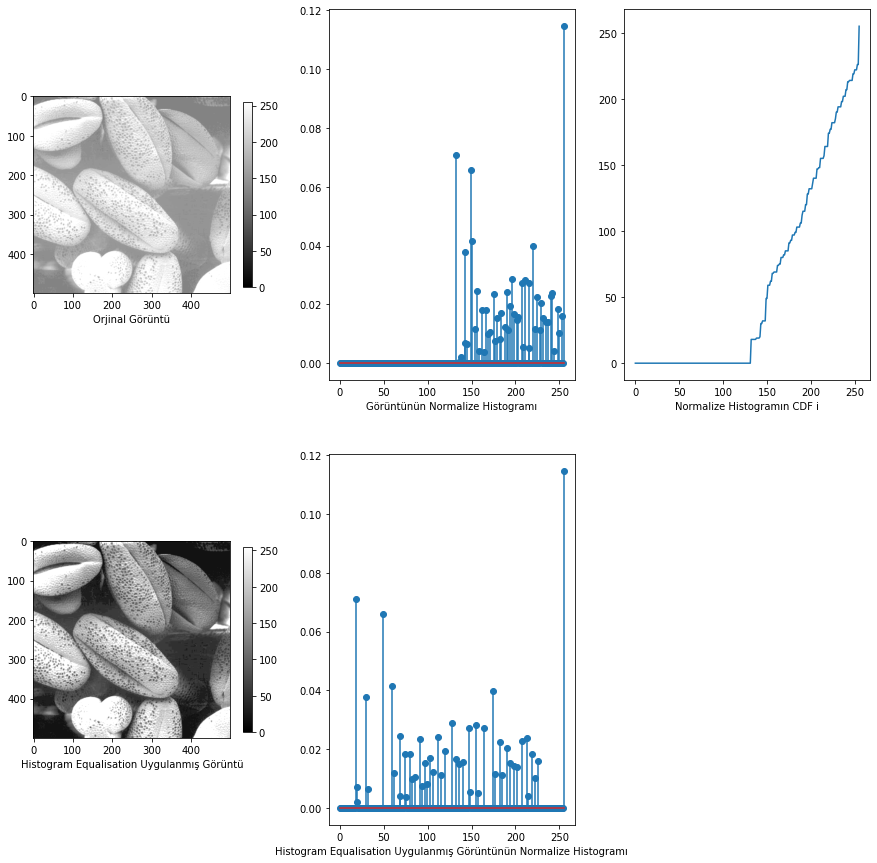

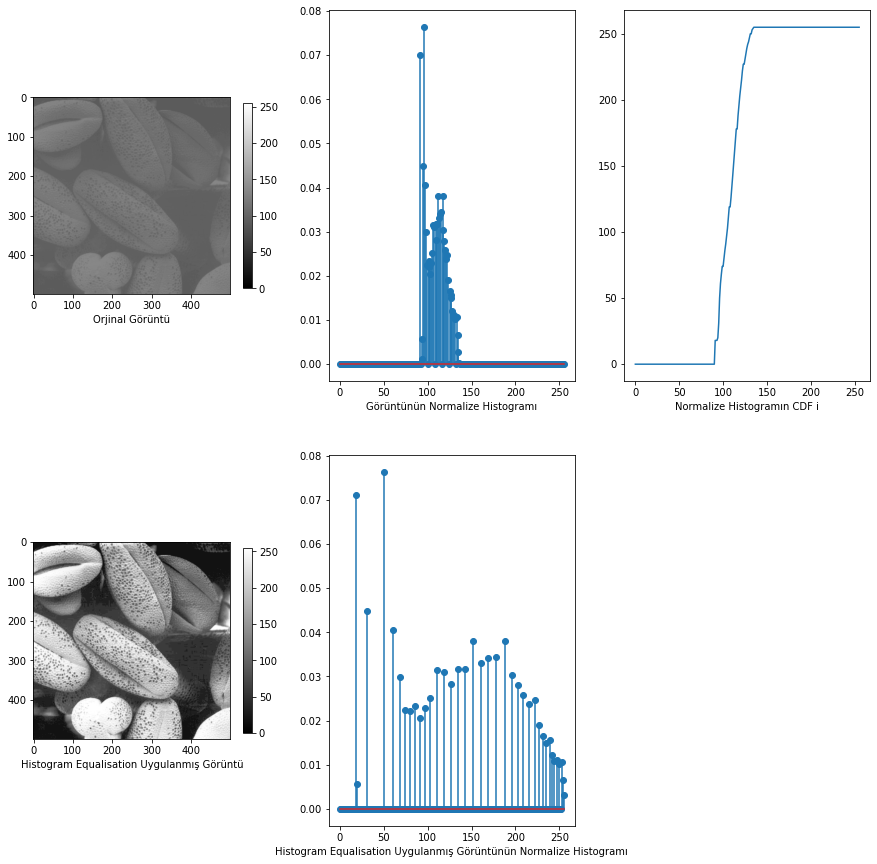

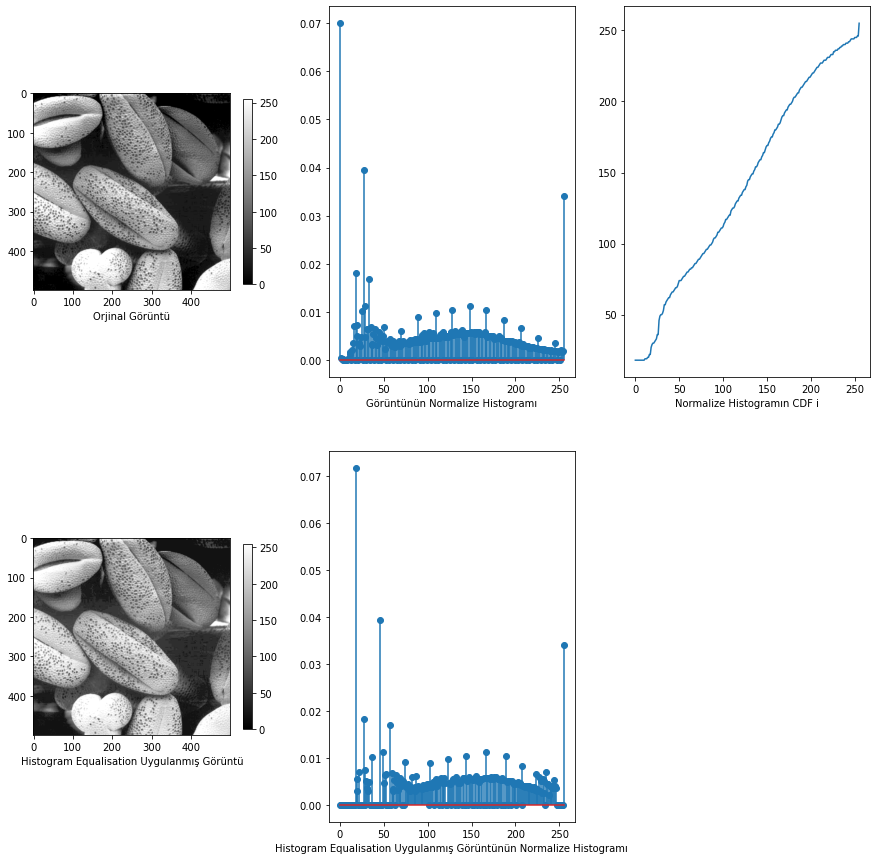

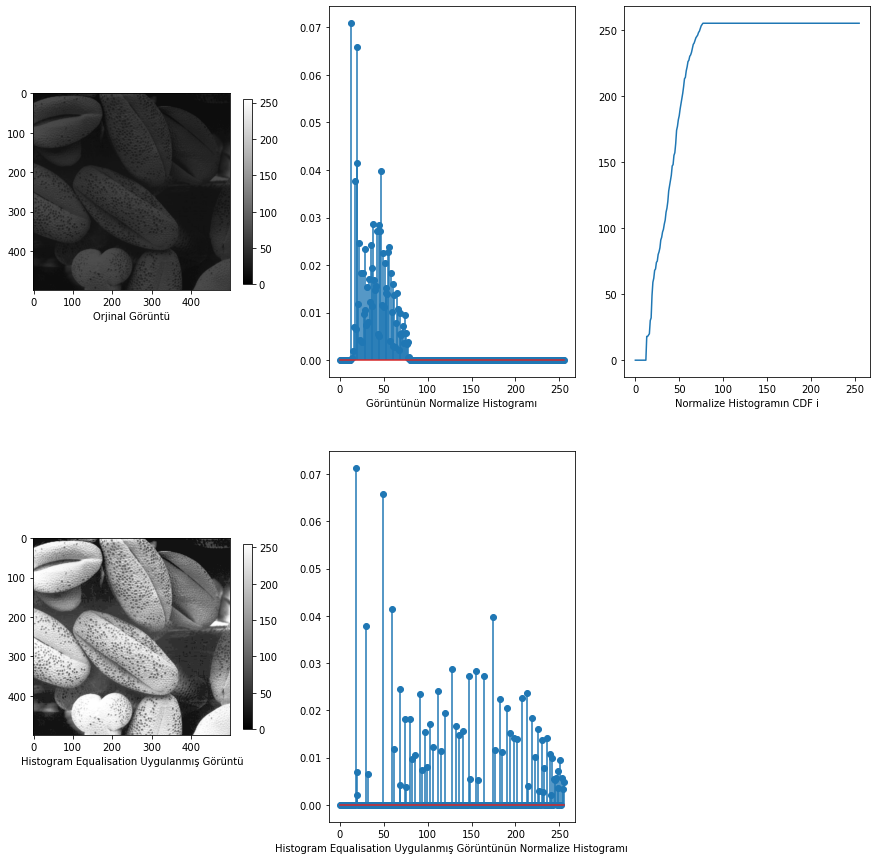

In [19]:
name,w,h,res,pixels = mypgmread('Fig0320(1)(top_left).pgm')
pixels = np.array(pixels)
pixels = np.reshape(pixels,(h,w))
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.5)


hr=mypgmhistogram(w,h,res,pixels,'Normalise')
plt.subplot(2,3,2)
plt.xlabel('Görüntünün Normalize Histogramı')
plt.stem(hr)

pixels,s=mypgmhistogrameq(w,h,res,pixels)
plt.subplot(2,3,3)
plt.xlabel('Normalize Histogramın CDF i')
plt.plot(s)

plt.subplot(2,3,4)
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.xlabel('Histogram Equalisation Uygulanmış Görüntü')
plt.colorbar(shrink=0.5)

hr=mypgmhistogram(w,h,res,pixels,'Normalise')
plt.subplot(2,3,5)
plt.xlabel('Histogram Equalisation Uygulanmış Görüntünün Normalize Histogramı')
plt.stem(hr)







name,w,h,res,pixels = mypgmread('Fig0320(2)(2nd_from_top).pgm')
pixels = np.array(pixels)
pixels = np.reshape(pixels,(h,w))
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.5)


hr=mypgmhistogram(w,h,res,pixels,'Normalise')
plt.subplot(2,3,2)
plt.xlabel('Görüntünün Normalize Histogramı')
plt.stem(hr)

pixels,s=mypgmhistogrameq(w,h,res,pixels)
plt.subplot(2,3,3)
plt.xlabel('Normalize Histogramın CDF i')
plt.plot(s)

plt.subplot(2,3,4)
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.xlabel('Histogram Equalisation Uygulanmış Görüntü')
plt.colorbar(shrink=0.5)

hr=mypgmhistogram(w,h,res,pixels,'Normalise')
plt.subplot(2,3,5)
plt.xlabel('Histogram Equalisation Uygulanmış Görüntünün Normalize Histogramı')
plt.stem(hr)




name,w,h,res,pixels = mypgmread('Fig0320(3)(third_from_top).pgm')
pixels = np.array(pixels)
pixels = np.reshape(pixels,(h,w))
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.5)


hr=mypgmhistogram(w,h,res,pixels,'Normalise')
plt.subplot(2,3,2)
plt.xlabel('Görüntünün Normalize Histogramı')
plt.stem(hr)

pixels,s=mypgmhistogrameq(w,h,res,pixels)
plt.subplot(2,3,3)
plt.xlabel('Normalize Histogramın CDF i')
plt.plot(s)

plt.subplot(2,3,4)
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.xlabel('Histogram Equalisation Uygulanmış Görüntü')
plt.colorbar(shrink=0.5)

hr=mypgmhistogram(w,h,res,pixels,'Normalise')
plt.subplot(2,3,5)
plt.xlabel('Histogram Equalisation Uygulanmış Görüntünün Normalize Histogramı')
plt.stem(hr)






name,w,h,res,pixels = mypgmread('Fig0320(4)(bottom_left).pgm')
pixels = np.array(pixels)
pixels = np.reshape(pixels,(h,w))
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.5)


hr=mypgmhistogram(w,h,res,pixels,'Normalise')
plt.subplot(2,3,2)
plt.xlabel('Görüntünün Normalize Histogramı')
plt.stem(hr)

pixels,s=mypgmhistogrameq(w,h,res,pixels)
plt.subplot(2,3,3)
plt.xlabel('Normalize Histogramın CDF i')
plt.plot(s)

plt.subplot(2,3,4)
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.xlabel('Histogram Equalisation Uygulanmış Görüntü')
plt.colorbar(shrink=0.5)

hr=mypgmhistogram(w,h,res,pixels,'Normalise')
plt.subplot(2,3,5)
plt.xlabel('Histogram Equalisation Uygulanmış Görüntünün Normalize Histogramı')
plt.stem(hr)


#### Orjinal görüntünün CDF'inin orjinal görüntünün PDF'inin sıkıştığı aralıkta hızlı arttığını(3. örnek daha dengeli olduğu için hemen hemen lineer) diğer aralıklarda sabit olduğunu gözlemliyoruz. Bu da görüntünün PDF'inin sıkıştığı aralıklarda Gri seviyesindeki ufak değişikliklerin CDF'te daha büyük değişiklik yarattığını ve bu sayede Histogram Equalisation tekniğinin çıkış görselinde daha dengeli yayılmış daha sabit gözüken bir PDF e sahip görüntü çıkardığını gözlemliyoruz.

### 2) Laplacian Filtreleme

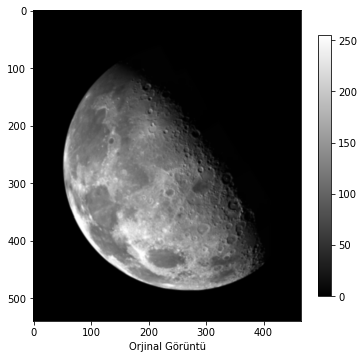

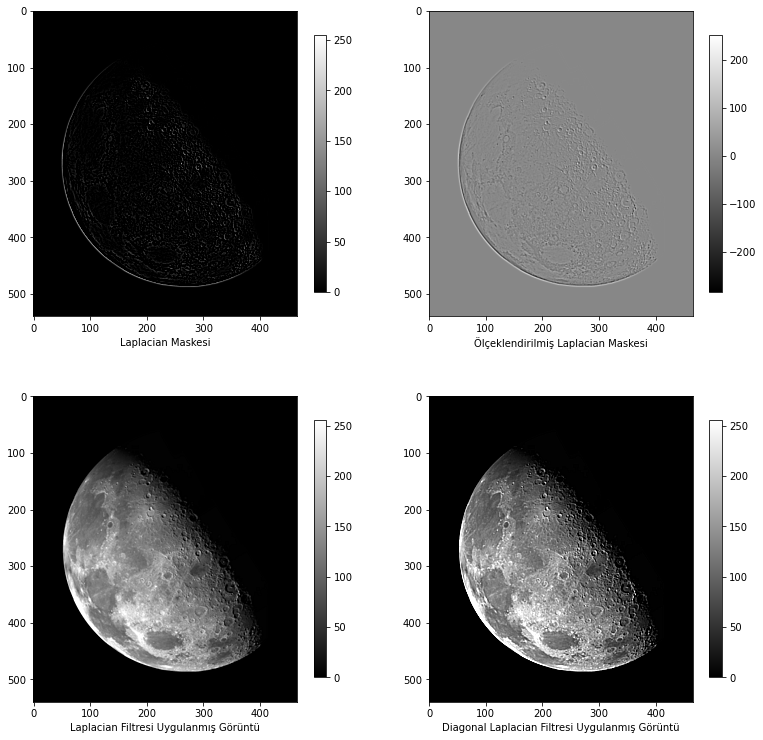

In [20]:
name,w,h,res,pixels2 = mypgmread('Fig0338(a)(blurry_moon).pgm')
pixels2 = np.array(pixels2)
pixels2 = np.reshape(pixels2,(h,w))
plt.figure(figsize = (6,6))
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels2, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.8)


name,w,h,res,pixels = mypgmread('Fig0338(a)(blurry_moon).pgm')
pixels=my_pgm_diagonal_laplacian_mask(pixels,w,h)
plt.figure(figsize = (13,13))
plt.subplot(2,2,1)
plt.xlabel('Laplacian Maskesi')
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.8)



name,w,h,res,pixels = mypgmread('Fig0338(a)(blurry_moon).pgm')
pixels=my_pgm_diagonal_laplacian_mask(pixels,w,h)
plt.subplot(2,2,2)
plt.xlabel('Ölçeklendirilmiş Laplacian Maskesi')
plt.imshow(pixels, cmap="gray")#python automatically scales the images so we do not need to scale the laplacian mask
plt.colorbar(shrink=0.8)



pixels4=my_pgm_laplacian_filter(pixels2,w,h)
pixels4 = np.array(pixels4)
pixels4 = np.reshape(pixels4,(h,w))
plt.subplot(2,2,3)
plt.xlabel('Laplacian Filtresi Uygulanmış Görüntü')
plt.imshow(pixels4, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.8)



pixels4=my_pgm_diagonal_laplacian_filter(pixels2,w,h)
pixels4 = np.array(pixels4)
pixels4 = np.reshape(pixels4,(h,w))
plt.subplot(2,2,4)
plt.xlabel('Diagonal Laplacian Filtresi Uygulanmış Görüntü')
plt.imshow(pixels4, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.8)


#### Laplacian operatörü türev yani değişim hesaplamamızı sağlıyan bir operatördür. Bu uygulamada laplacian maskesi laplacian operatörünün numerik bir yaklaşımıdır. Türevin büyük olduğu bölgeler değişimin büyük olduğu bölgeleri yani kenar ve sınır bölgelerini belirlememizi sağlıyor ve bu maskeyi kullanarak oluşturduğumuz maske görüntüsünü orjinal görüntüden çıkardığımızda kenarların daha belirgin olduğu, yani daha net bir görüntü elde ediyoruz. Bu uygulamada Diagonal laplacian filtresi normal laplacian filtresinin merkezde -8 diğer değerleri 1 olan 3x3 bir maske olan bir alternatifidir. Bu görsel için kenar bölgelerin abartıldığı yani diagonal laplacian daha güzel gözüken bir sonuç verdi. Bir de lena görseline bu filtreleri uygulayarak inceliyelim

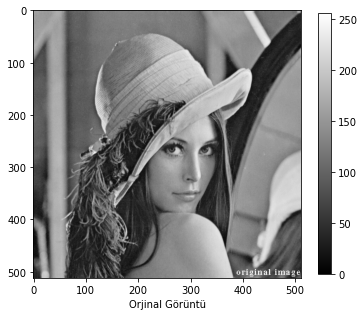

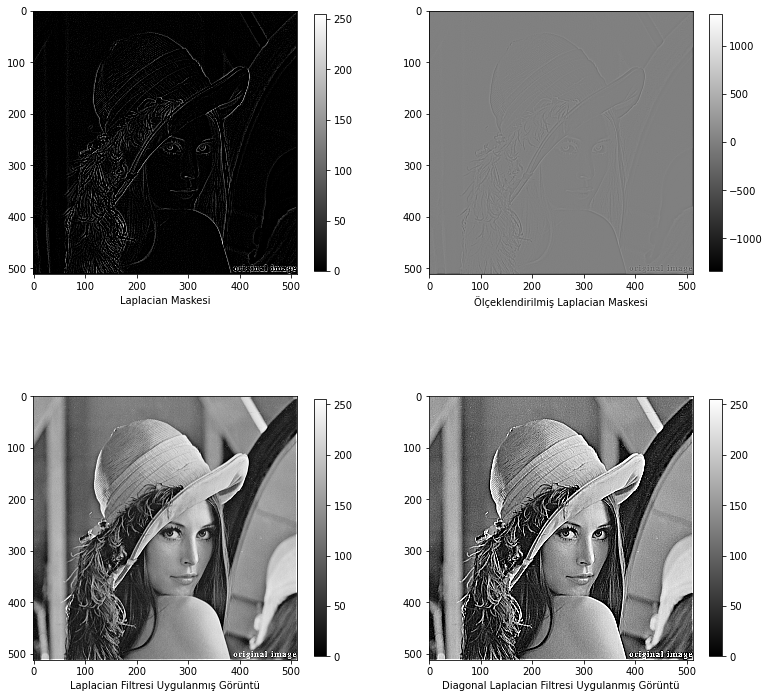

In [21]:
ame,w,h,res,pixels2 = mypgmread('lena.pgm')
pixels2 = np.array(pixels2)
pixels2 = np.reshape(pixels2,(h,w))
plt.figure(figsize = (6,6))
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels2, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.8)


name,w,h,res,pixels = mypgmread('lena.pgm')
pixels=my_pgm_diagonal_laplacian_mask(pixels,w,h)
plt.figure(figsize = (13,13))
plt.subplot(2,2,1)
plt.xlabel('Laplacian Maskesi')
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.8)



name,w,h,res,pixels = mypgmread('lena.pgm')
pixels=my_pgm_diagonal_laplacian_mask(pixels,w,h)
plt.subplot(2,2,2)
plt.xlabel('Ölçeklendirilmiş Laplacian Maskesi')
plt.imshow(pixels, cmap="gray")#python automatically scales the images so we do not need to scale the laplacian mask
plt.colorbar(shrink=0.8)



pixels4=my_pgm_laplacian_filter(pixels2,w,h)
pixels4 = np.array(pixels4)
pixels4 = np.reshape(pixels4,(h,w))
plt.subplot(2,2,3)
plt.xlabel('Laplacian Filtresi Uygulanmış Görüntü')
plt.imshow(pixels4, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.8)



pixels4=my_pgm_diagonal_laplacian_filter(pixels2,w,h)
pixels4 = np.array(pixels4)
pixels4 = np.reshape(pixels4,(h,w))
plt.subplot(2,2,4)
plt.xlabel('Diagonal Laplacian Filtresi Uygulanmış Görüntü')
plt.imshow(pixels4, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.8)

#### Lena görselinde daha az abartılı olan laplacian filtresi subjektif olarak daha güzel bir sonuç vermiştir. Görüntü iyileştirme tekniklerini görsele uygularken uygulanan duruma ve görsele göre uygulamamız sonucu etkileyen bir faktördür.

### 3) Unsharp Filtreleme ve Highboost filtreleme

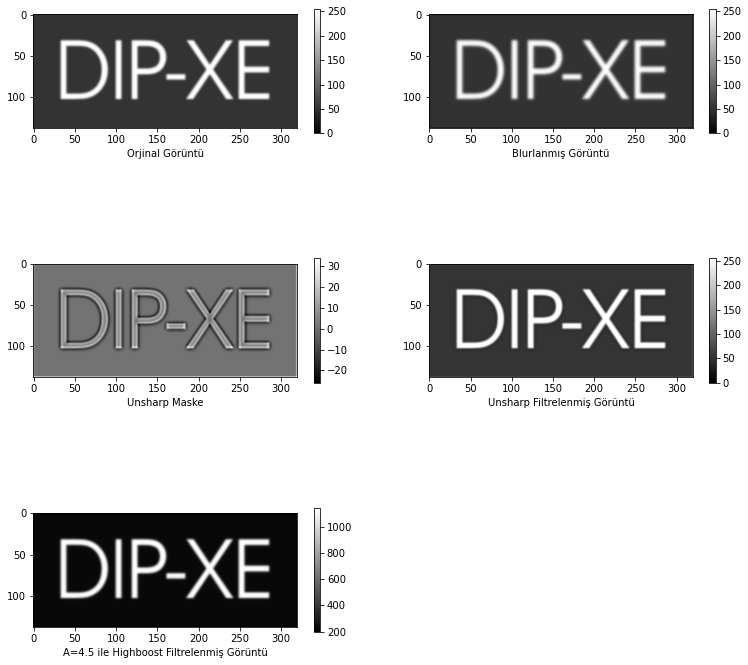

In [22]:
name,w,h,res,pixels = mypgmread('Fig0340(a)(dipxe_text).pgm')
pixels = np.array(pixels)
pixels = np.reshape(pixels,(h,w))


plt.figure(figsize = (13,13))
plt.subplot(3,2,1)
plt.xlabel('Orjinal Görüntü')
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.6)

average,pixels,fs=mypgmunsharp(pixels,3)


plt.subplot(3,2,2)
plt.xlabel('Blurlanmış Görüntü')
plt.imshow(average, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.6)


plt.subplot(3,2,3)
plt.xlabel('Unsharp Maske')
plt.imshow(fs, cmap="gray")
plt.colorbar(shrink=0.6)


plt.subplot(3,2,4)
plt.xlabel('Unsharp Filtrelenmiş Görüntü')
plt.imshow(pixels, cmap="gray",vmin=0,vmax=255)
plt.colorbar(shrink=0.6)

name,w,h,res,pixels = mypgmread('Fig0340(a)(dipxe_text).pgm')
pixels = mypgmhighboost(pixels,3,4.5)
plt.subplot(3,2,5)
plt.xlabel('A=4.5 ile Highboost Filtrelenmiş Görüntü')
plt.imshow(pixels, cmap="gray")
plt.colorbar(shrink=0.6)


#### Unsharp filtre kullanarak görüntünün blurlu halini orjinalinden çıkararak daha net bir görüntü elde ettik. Bu örnek için Highboost filtreleme çok daha net bir görüntü elde etmemizi sağladı. Highboost filtering arkaplan renginin de daha zenginleşmesini sağladı.